In [21]:
import pandas as pd

In [22]:
df = pd.read_csv("email.csv")
# df_test = pd.read_csv("test_emails.csv")
df.head()
#Label 1 = spam, Label 0 = ham

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
#Check for unique labels. It is expected to be 2, spam and ham
df['Category'].nunique()

3

In [24]:
#Remove unexpected labels
df.Category = df.Category[(df.Category == 'ham') | (df.Category == 'spam')]
df.Category.nunique()

2

In [25]:
#Checking for Null Values
df.isna().any()

Category     True
Message     False
dtype: bool

In [26]:
#Remove Null Values
df = df.dropna()
df.isna().any()

Category    False
Message     False
dtype: bool

In [27]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [28]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [29]:
#Convert Labels and creating new column. Spam = 1, Ham = 0
df['Category_n'] = df.Category.apply(lambda x: 0 if x == 'ham' else 1)
df

,Category,Message,Category_n
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will ü b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [30]:
from sklearn.model_selection import train_test_split
X = df.Message
y = df.Category_n

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

1978    Reply to win £100 weekly! Where will the 2006 ...
3989    Hello. Sort of out in town already. That . So ...
3935     How come guoyang go n tell her? Then u told her?
4078    Hey sathya till now we dint meet not even a si...
4086    Orange brings you ringtones from all time Char...
                              ...                        
3772    Hi, wlcome back, did wonder if you got eaten b...
5191                               Sorry, I'll call later
5226        Prabha..i'm soryda..realy..frm heart i'm sory
5390                           Nt joking seriously i told
860               Did he just say somebody is named tampa
Name: Message, Length: 4457, dtype: object

In [31]:
# from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Assuming the dataset has 'text' and 'label' columns
texts = df['Message']
labels = df['Category']

# Convert text data to numerical data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the number of features
X = vectorizer.fit_transform(texts).toarray()

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [66]:
import mlrose_hiive
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import numpy as np

hidden_layers = (2,) 

# Define a fitness function to optimize the neural network weights
def fitness_function(weights):
    weights = weights.reshape(hidden_layers[0], -1)
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, max_iter=1)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_train)
    return -accuracy_score(y_train, y_pred)

In [67]:
# Initialize the weights with a random guess
input_size = X_train.shape[1]
initial_weights = np.random.rand(hidden_layers[0], input_size)

In [68]:
# Define the optimization problem
problem = mlrose_hiive.ContinuousOpt(length=initial_weights.size, fitness_fn=mlrose_hiive.CustomFitness(fitness_function), maximize=False, min_val=-1, max_val=1)

In [69]:
# Perform simulated annealing
schedule = mlrose_hiive.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)
best_state, best_fitness, _ = mlrose_hiive.simulated_annealing(problem, schedule=schedule, max_attempts=10, max_iters=100, random_state=42)

In [70]:
# Reshape the optimized weights and assign to the neural network
optimized_weights = best_state.reshape(hidden_layers[0], input_size)
mlp_optimized = MLPClassifier(hidden_layer_sizes=hidden_layers, max_iter=500)
mlp_optimized.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(2,), max_iter=500)

In [71]:
# Evaluate the optimized model
y_pred_train_optimized = mlp_optimized.predict(X_train)
y_pred_test_optimized = mlp_optimized.predict(X_test)

train_accuracy_optimized = accuracy_score(y_train, y_pred_train_optimized)
test_accuracy_optimized = accuracy_score(y_test, y_pred_test_optimized)

print(f'Optimized Training Accuracy: {train_accuracy_optimized:.4f}')
print(f'Optimized Testing Accuracy: {test_accuracy_optimized:.4f}')

Optimized Training Accuracy: 0.9998
Optimized Testing Accuracy: 0.9919


Optimized Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       966
        spam       0.99      0.95      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



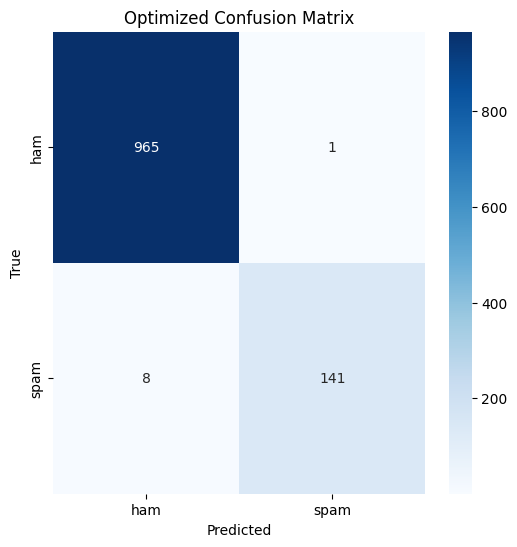

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report for optimized model
print('Optimized Classification Report:')
print(classification_report(y_test, y_pred_test_optimized, target_names=label_encoder.classes_))

# Confusion matrix for optimized model
conf_matrix_optimized = confusion_matrix(y_test, y_pred_test_optimized)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_optimized, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Optimized Confusion Matrix')
plt.show()
